In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Configuracion y carga del dataset

In [3]:
DATASET_PATH = Path("..") / "intents_dataset.csv"  # ajustá si tu archivo se llama distinto
df = pd.read_csv(DATASET_PATH)

df.head(10)

,text,intent
0,cuanto gaste este mes,get_expenses_total
1,total de gastos del mes,get_expenses_total
2,quiero saber cuanto gaste,get_expenses_total
3,cuanto fue mi gasto total,get_expenses_total
4,cuanto llevo gastado,get_expenses_total
5,decime cuanto gaste este mes,get_expenses_total
6,cuanto dinero gaste,get_expenses_total
7,cuanto se me fue en gastos,get_expenses_total
8,total gastado este mes,get_expenses_total
9,cuanto gaste hasta ahora,get_expenses_total


# Analisis de datos

## Distribución de clases

In [4]:
intent_counts = df["intent"].value_counts()
intent_counts

intent
unknown                     36
get_expenses_total          35
get_expenses_by_category    35
get_movements               35
get_balance                 34
help                        34
Name: count, dtype: int64

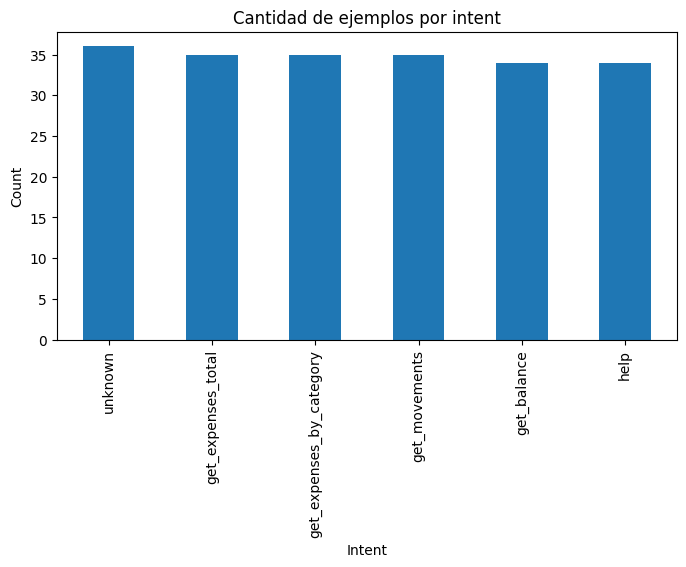

In [5]:
plt.figure(figsize=(8,4))
intent_counts.plot(kind="bar")
plt.title("Cantidad de ejemplos por intent")
plt.xlabel("Intent")
plt.ylabel("Count")
plt.show()

## Textos

In [6]:
df["text_len"] = df["text"].str.len()
df["text_len"].describe()

count    209.000000
mean      17.784689
std        7.196858
min        1.000000
25%       14.000000
50%       19.000000
75%       23.000000
max       31.000000
Name: text_len, dtype: float64

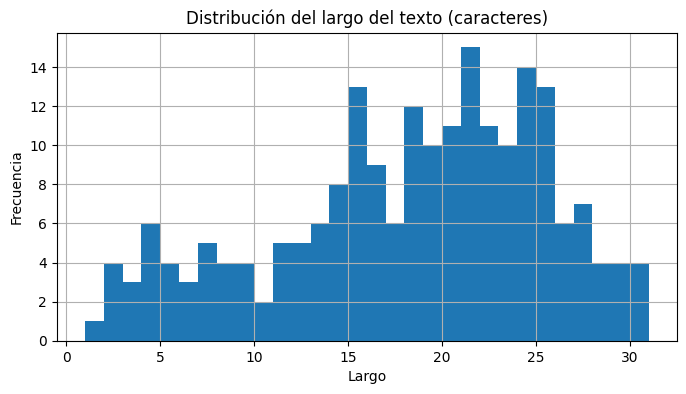

In [7]:
plt.figure(figsize=(8,4))
df["text_len"].hist(bins=30)
plt.title("Distribución del largo del texto (caracteres)")
plt.xlabel("Largo")
plt.ylabel("Frecuencia")
plt.show()

## Ejemplos por intent

In [9]:
for intent in intent_counts.index:
    print(f"=== {intent} ===")
    display(df[df["intent"] == intent].sample(min(5, intent_counts[intent]), random_state=42)[["text"]])

=== unknown ===


,text
208,👍
186,si
199,mmm no se
203,ok gracias
189,que


=== get_expenses_total ===


,text
26,cuanto se gasto en total
13,cuanto llevo gastado este mes
24,gaste mucho este mes
21,cuanto llevo gastado hoy
15,cuanto gaste el mes pasado


=== get_expenses_by_category ===


,text
61,gastos por cada categoria
48,ver gastos por grupo
59,ver resumen por categoria
56,en que se fue la plata
50,comparar categorias de gastos


=== get_movements ===


,text
96,ver compras
83,movimientos del mes
94,ver ultimos movimientos
91,ver gastos uno por uno
85,listar movimientos


=== get_balance ===


,text
120,cuanto tengo ahora
124,estado del saldo
132,saldo hoy
131,ver cuanto tengo
113,decime mi saldo


=== help ===


,text
154,como ver gastos
158,que puedo pedir
166,que preguntas puedo hacer
165,como consultar categorias
147,como te uso


# 3) Split train/test (con estratificación)

In [10]:
X = df["text"]
y = df["intent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)

(146, 63)

# Baseline model (TF-IDF + Logistic Regression)

## Definir pipeline

In [11]:
pipeline = Pipeline(
    steps=[
        ("vectorizer", TfidfVectorizer(
            lowercase=True,
            ngram_range=(1, 2),
            max_features=5000,
        )),
        ("classifier", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
        )),
    ]
)

## Entrenar

In [12]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


# Métricas

## Accuracy + classification report

In [13]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

Accuracy: 0.873015873015873

                          precision    recall  f1-score   support

             get_balance       0.91      1.00      0.95        10
get_expenses_by_category       0.77      0.91      0.83        11
      get_expenses_total       1.00      0.80      0.89        10
           get_movements       0.73      0.73      0.73        11
                    help       1.00      0.80      0.89        10
                 unknown       0.92      1.00      0.96        11

                accuracy                           0.87        63
               macro avg       0.89      0.87      0.87        63
            weighted avg       0.88      0.87      0.87        63



## Confusion Matrix (visual)

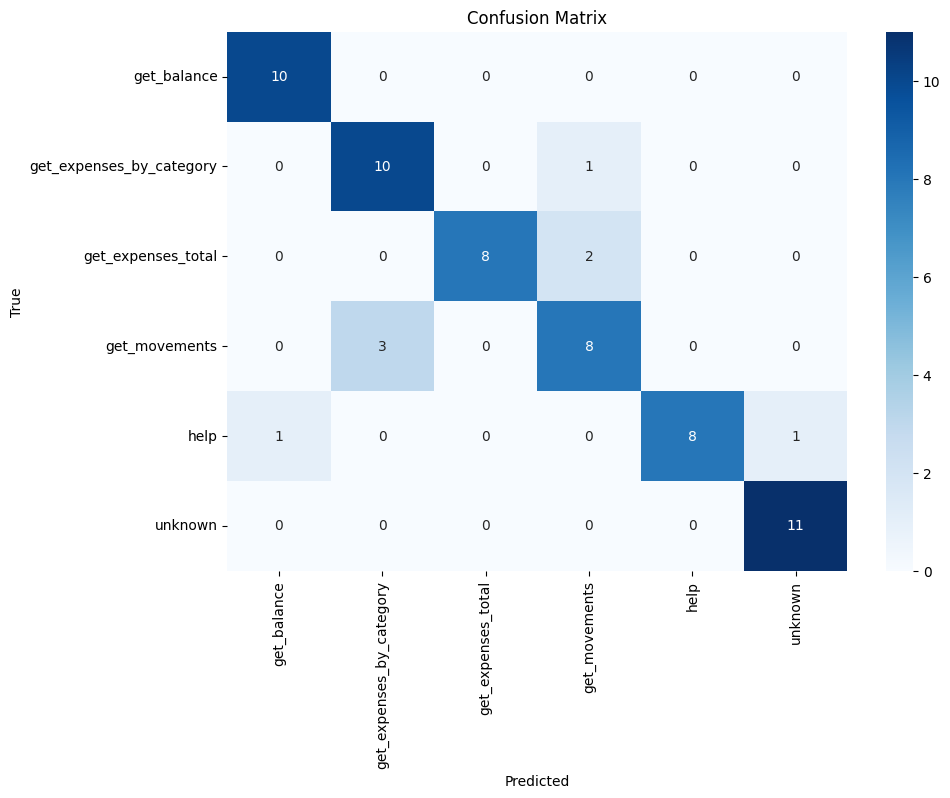

In [14]:
labels = list(pipeline.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10,7))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=labels, yticklabels=labels,
    cmap="Blues"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Análisis de errores

In [15]:
errors = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "pred": y_pred
})

errors = errors[errors["true"] != errors["pred"]]
errors.head(20)

,text,true,pred
4,que gastos hice,get_movements,get_expenses_by_category
31,ver categorias,get_expenses_by_category,get_movements
33,que opciones tengo,help,get_balance
40,total de gastos recientes,get_expenses_total,get_movements
50,que comandos hay,help,unknown
54,ver total de gastos,get_expenses_total,get_movements
57,listado de gastos,get_movements,get_expenses_by_category
62,listar gastos,get_movements,get_expenses_by_category


### Top confusiones

In [16]:
errors.groupby(["true", "pred"]).size().sort_values(ascending=False).head(20)

true                      pred                    
get_movements             get_expenses_by_category    3
get_expenses_total        get_movements               2
get_expenses_by_category  get_movements               1
help                      get_balance                 1
                          unknown                     1
dtype: int64

## Probabilidades y umbral de confianza

In [17]:
probas = pipeline.predict_proba(X_test)
classes = pipeline.classes_

max_proba = probas.max(axis=1)
pred_class = classes[probas.argmax(axis=1)]

proba_df = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "pred": pred_class,
    "confidence": max_proba
})

proba_df.head(10)


,text,true,pred,confidence
0,necesito saber cuanto gaste,get_expenses_total,get_expenses_total,0.521261
1,mmm no se,unknown,unknown,0.406873
2,gastos por tipo de consumo,get_expenses_by_category,get_expenses_by_category,0.596999
3,cualquiera,unknown,unknown,0.240394
4,que gastos hice,get_movements,get_expenses_by_category,0.248840
5,como consultar,help,help,0.526511
6,ver balance actual,get_balance,get_balance,0.344155
7,total de lo que gaste,get_expenses_total,get_expenses_total,0.367149
8,dale,unknown,unknown,0.240394
9,que puedo consultar aca,help,help,0.372233


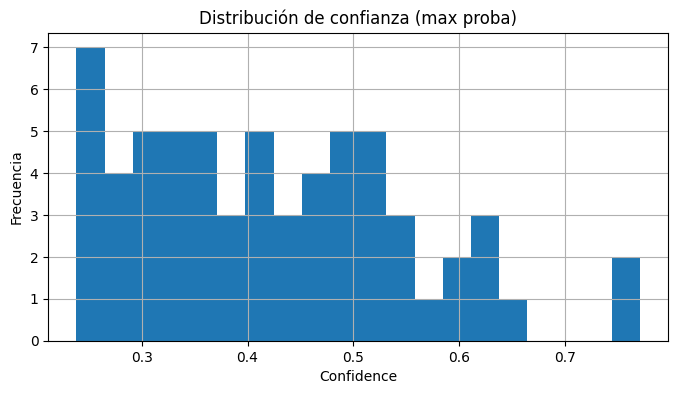

In [18]:
plt.figure(figsize=(8,4))
proba_df["confidence"].hist(bins=20)
plt.title("Distribución de confianza (max proba)")
plt.xlabel("Confidence")
plt.ylabel("Frecuencia")
plt.show()

# Guardar el modelo entrenado

In [19]:
from joblib import dump
from pathlib import Path

OUT_DIR = Path("..") / "model"
OUT_DIR.mkdir(exist_ok=True)

MODEL_PATH = OUT_DIR / "intent_classifier.joblib"
dump(pipeline, MODEL_PATH)

MODEL_PATH

WindowsPath('../model/intent_classifier.joblib')